# Hand gestures recognition for TV control.

#### Authors:
##### 1. Chaitanya Chembeti - Group facilitator
##### 2. Kumaraguru Muthuraj

### Problem Statement
### We want to use the TV's webcam to detect 5 gestures to control the videos without a remote.
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
There are 5 gestures under consideration.
 
- Thumbs Up - Increase the volume.
- Thumbs Down - Decrease the volume.
- Left Swipe - 'Move' backwards 10 seconds.
- Right Swipe - 'Move' forward 10 seconds.
- Stop - Pause the movie.
- Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator using Python's yield feature should be able to take a batch of videos as input and producec the images without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. 

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [5]:
!pip install keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [6]:
# Importing the necessary libraries

import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

Set a random seed

In [7]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [8]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Read the folder names for training and validation. You also set a reasonable `batch_size` to make use of the GPU.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [10]:
project_folder='datasets/Project_data'

##### Plotting

In [14]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [15]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Build the model using `Conv3D` and `MaxPooling3D`. You would want to use `TimeDistributed` when buildind model. The last layer is the softmax. Design for good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Experiment with some model

In [9]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

##### Experiment CROPPING the images

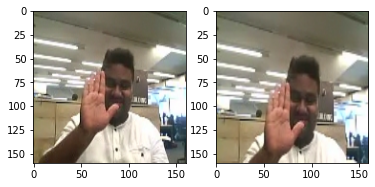

In [11]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [12]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### Team discussion for using the parameters.

##### Conclude on the parameters like batch size, frames and epochs.

In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.5019 - categorical_accuracy: 0.4178
Epoch 00001: val_loss improved from inf to 2.24163, saving model to model_init_2021-07-2917_48_17.497176/model-00001-1.50193-0.41780-2.24163-0.16000.h5
34/34 [==============================] - 142s 4s/step - loss: 1.5019 - categorical_accuracy: 0.4178 - val_loss: 2.2416 - val_categorical_accuracy: 0.1600
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 1.0153 - categorical_accuracy: 0.6124
Epoch 00002: val_loss did not improve from 2.24163
34/34 [==============================] - 143s 4s/step - loss: 1.0153 - categorical_accuracy: 0.6124 - val_loss: 3.6208 - val_categorical_accuracy: 0.1700


In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.4789 - categorical_accuracy: 0.4389
Epoch 00001: val_loss improved from inf to 4.42974, saving model to model_init_2021-07-2917_53_09.372770/model-00001-1.47894-0.43891-4.42974-0.21000.h5
45/45 [==============================] - 166s 4s/step - loss: 1.4789 - categorical_accuracy: 0.4389 - val_loss: 4.4297 - val_categorical_accuracy: 0.2100
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.9007 - categorical_accuracy: 0.6591
Epoch 00002: val_loss did not improve from 4.42974
45/45 [==============================] - 170s 4s/step - loss: 0.9007 - categorical_accuracy: 0.6591 - val_loss: 9.8229 - val_categorical_accuracy: 0.2100


In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.4560 - categorical_accuracy: 0.4646
Epoch 00001: val_loss improved from inf to 3.44622, saving model to model_init_2021-07-2917_58_50.777929/model-00001-1.45601-0.46456-3.44622-0.16000.h5
23/23 [==============================] - 91s 4s/step - loss: 1.4560 - categorical_accuracy: 0.4646 - val_loss: 3.4462 - val_categorical_accuracy: 0.1600
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 0.7934 - categorical_accuracy: 0.7059
Epoch 00002: val_loss did not improve from 3.44622
23/23 [==============================] - 91s 4s/step - loss: 0.7934 - categorical_accuracy: 0.7059 - val_loss: 5.8629 - val_categorical_accuracy: 0.1700


- From the above runs we concluded that **"image resolution"** and **number of frames** have more importance than **batch_size**
- Batch Size around 15-30.
- Resolution to be derived based on model performance.


## Model 1
### Base Model - Batch Size = 30 and No. of Epochs = 15

In [16]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120, image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=20, batch_size=30, num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_17 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 60, 60, 32)   

In [18]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 699269
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.5728 - categorical_accuracy: 0.4042
Epoch 00001: val_loss improved from inf to 1.50582, saving model to model_init_2021-07-2918_01_58.332962/model-00001-1.57285-0.40422-1.50582-0.33000.h5
23/23 [==============================] - 100s 4s/step - loss: 1.5728 - categorical_accuracy: 0.4042 - val_loss: 1.5058 - val_categorical_accuracy: 0.3300
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.0927 - categorical_accuracy: 0.5777
Epoch 00002: val_loss did not improve from 1.50582
23/23 [==============================] - 97s 4s/step - loss: 1.0927 - categorical_accuracy: 0.5777 - val_loss: 1.8703 - val_categorical_accuracy: 0.1900
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 0.8293 - categorical_accuracy: 0.6968
Epoch 00003: val_loss did not improve from 1.50582
23/23 [==============================] - 96s 4s/step - loss: 0.8293 - categorical_accuracy: 0.6968 -

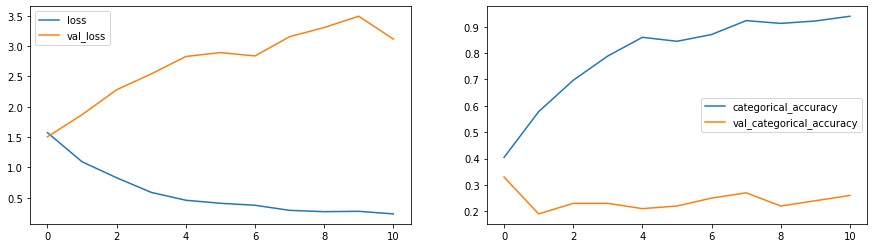

In [19]:
plot(history_model1)

##### Fill results here...

## Model 2  
### Adding dropout layers - Batch Size = 30 and No. of Epochs = 15

In [20]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=120,image_width=120)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=30,num_epochs=15)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_20 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_21 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 10, 60, 60, 32)   

In [21]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 1967813
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.9549 - categorical_accuracy: 0.3748
Epoch 00001: val_loss improved from inf to 3.11045, saving model to model_init_2021-07-2918_19_48.121233/model-00001-1.95489-0.37481-3.11045-0.21000.h5
23/23 [==============================] - 179s 8s/step - loss: 1.9549 - categorical_accuracy: 0.3748 - val_loss: 3.1104 - val_categorical_accuracy: 0.2100
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.5058 - categorical_accuracy: 0.4706
Epoch 00002: val_loss did not improve from 3.11045
23/23 [==============================] - 181s 8s/step - loss: 1.5058 - categorical_accuracy: 0.4706 - val_loss: 4.0470 - val_categorical_accuracy: 0.1500
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.2235 - categorical_accuracy: 0.5784
Epoch 00003: val_loss did not improve from 3.11045
23/23 [==============================] - 183s 8s/step - loss: 1.2235 - categorical_accuracy: 0.578

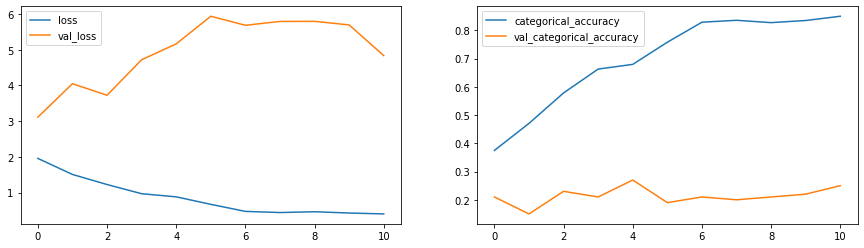

In [22]:
plot(history_model2)

##### We can see  val_loss did not improve from 1.24219 so earlystopping stops the epoch automatically!! 
RESULTS HERE--- DOCUMENT
- Last Epoch stop on 15/25!! good job earlystopping ;)
- Best weights save automatically. The validation accuracy of 52% and training accuracy of 65%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

## Model 3 
### Reduce filter size to (2,2,2), Batch Size = 30 and No. of Epochs = 15

In [23]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120, image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=20, batch_size=30, num_epochs=15)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2), dense_neurons=256, dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_24 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_25 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 10, 60, 60, 32)   

In [25]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 2.1302 - categorical_accuracy: 0.3288
Epoch 00001: val_loss improved from inf to 1.81436, saving model to model_init_2021-07-2918_53_24.697579/model-00001-2.13022-0.32881-1.81436-0.16000.h5
23/23 [==============================] - 181s 8s/step - loss: 2.1302 - categorical_accuracy: 0.3288 - val_loss: 1.8144 - val_categorical_accuracy: 0.1600
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.4418 - categorical_accuracy: 0.5151
Epoch 00002: val_loss did not improve from 1.81436
23/23 [==============================] - 181s 8s/step - loss: 1.4418 - categorical_accuracy: 0.5151 - val_loss: 2.9756 - val_categorical_accuracy: 0.1300
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.2472 - categorical_accuracy: 0.5724
Epoch 00003: val_loss did not improve from 1.81436
23/23 [==============================] - 182s 8s/step - loss: 1.2472 - categorical_accuracy: 0.572

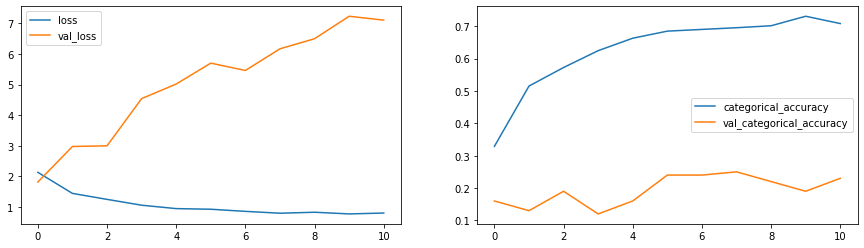

In [26]:
plot(history_model3)

#### RESULTS DOCUMENT
##### Model has a  best validation accuracy of 72% and training accuracy of 76% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 4
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [27]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_28 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_29 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 8, 60, 60, 16)    

In [29]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9991 - categorical_accuracy: 0.3529
Epoch 00001: val_loss improved from inf to 2.74144, saving model to model_init_2021-07-2919_27_14.868923/model-00001-1.99905-0.35294-2.74144-0.21000.h5
34/34 [==============================] - 148s 4s/step - loss: 1.9991 - categorical_accuracy: 0.3529 - val_loss: 2.7414 - val_categorical_accuracy: 0.2100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4053 - categorical_accuracy: 0.5166
Epoch 00002: val_loss did not improve from 2.74144
34/34 [==============================] - 148s 4s/step - loss: 1.4053 - categorical_accuracy: 0.5166 - val_loss: 3.9495 - val_categorical_accuracy: 0.1800
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3406 - categorical_accuracy: 0.5415
Epoch 00003: val_loss did not improve from 2.74144
34/34 [==============================] - 146s 4s/step - loss: 1.3406 - categorical_accuracy: 0.541

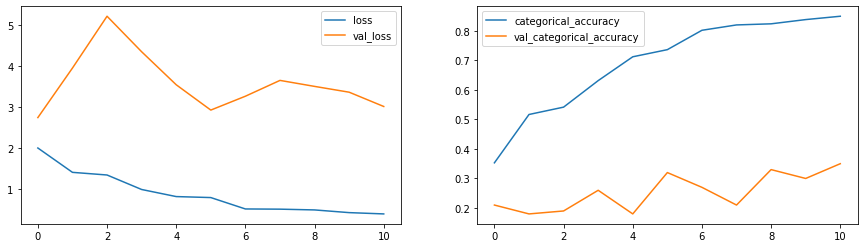

In [30]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 5
### Reducing the number of parameters

In [31]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [32]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_37 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 8, 50, 50, 32)    

In [33]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.8211 - categorical_accuracy: 0.3582
Epoch 00001: val_loss improved from inf to 1.79861, saving model to model_init_2021-07-2919_54_29.726126/model-00001-1.82105-0.35822-1.79861-0.16000.h5
34/34 [==============================] - 142s 4s/step - loss: 1.8211 - categorical_accuracy: 0.3582 - val_loss: 1.7986 - val_categorical_accuracy: 0.1600
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.1407 - categorical_accuracy: 0.5611
Epoch 00002: val_loss did not improve from 1.79861
34/34 [==============================] - 141s 4s/step - loss: 1.1407 - categorical_accuracy: 0.5611 - val_loss: 2.4027 - val_categorical_accuracy: 0.1600
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.8803 - categorical_accuracy: 0.6840
Epoch 00003: val_loss did not improve from 1.79861
34/34 [==============================] - 135s 4s/step - loss: 0.8803 - categorical_accuracy: 0.6840

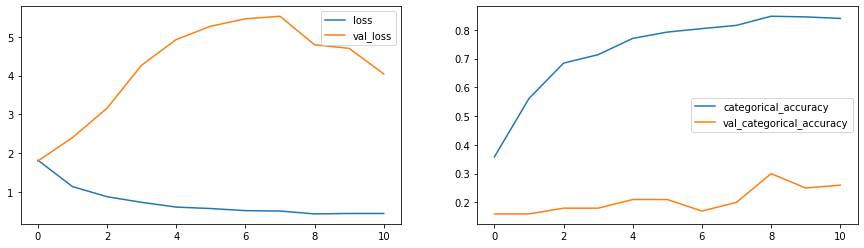

In [34]:
plot(history_model6)

#### DOCUMENT RESULTS HERE
###### For the above low memory foot print model, we get the best validation accuracy of 74%

## Model 6 - CNN- LSTM Model

In [16]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=15)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 64)   

In [37]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.3412 - categorical_accuracy: 0.4351
Epoch 00001: val_loss improved from inf to 1.67042, saving model to model_init_2021-07-2920_20_01.040157/model-00001-1.34117-0.43514-1.67042-0.22000.h5
34/34 [==============================] - 178s 5s/step - loss: 1.3412 - categorical_accuracy: 0.4351 - val_loss: 1.6704 - val_categorical_accuracy: 0.2200
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 0.9893 - categorical_accuracy: 0.6124
Epoch 00002: val_loss did not improve from 1.67042
34/34 [==============================] - 181s 5s/step - loss: 0.9893 - categorical_accuracy: 0.6124 - val_loss: 2.1211 - val_categorical_accuracy: 0.2300
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.7988 - categorical_accuracy: 0.6863
Epoch 00003: val_loss did not improve from 1.67042
34/34 [==============================] - 179s 5s/step - loss: 0.7988 - categorical_accuracy: 0.686

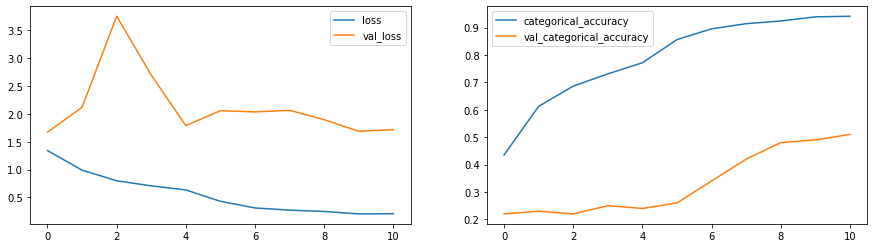

In [38]:
plot(history_model8)

##### For CNN - LSTM model we get a best validation accuracy of 85%
#### DOCUMENT THE RESULT

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Data augmentation and check the model performance.

In [39]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

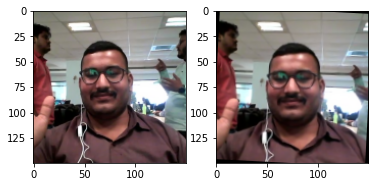

In [40]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=150, image_width=150)
test_generator.initialize_hyperparams(frames_to_sample=30, batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model 7 with Augmentation
### (2,2,2) Filter, 130x130 Image resolution

In [41]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [42]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=130, image_width=130)
conv_3d10.initialize_hyperparams(frames_to_sample=16, batch_size=20, num_epochs=15)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2), dense_neurons=256, dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_40 (Conv3D)           (None, 16, 130, 130, 16)  400       
_________________________________________________________________
activation_40 (Activation)   (None, 16, 130, 130, 16)  0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 16, 130, 130, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 8, 65, 65, 16)     0         
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 8, 65, 65, 32)     4128      
_________________________________________________________________
activation_41 (Activation)   (None, 8, 65, 65, 32)     0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 8, 65, 65, 32)   

In [43]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 2254133
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.9938 - categorical_accuracy: 0.3695
Epoch 00001: saving model to model_init_2021-07-2920_52_33.767024/model-00001-1.99379-0.36953-2.43103-0.16000.h5
34/34 [==============================] - 149s 4s/step - loss: 1.9938 - categorical_accuracy: 0.3695 - val_loss: 2.4310 - val_categorical_accuracy: 0.1600
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.2992 - categorical_accuracy: 0.5483
Epoch 00002: saving model to model_init_2021-07-2920_52_33.767024/model-00002-1.29924-0.54827-4.39417-0.12000.h5
34/34 [==============================] - 145s 4s/step - loss: 1.2992 - categorical_accuracy: 0.5483 - val_loss: 4.3942 - val_categorical_accuracy: 0.1200
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.0795 - categorical_accuracy: 0.6229
Epoch 00003: saving model to model_init_2021-07-2920_52_33.767024/model-00003-1.07952-0.62293-6.00421-0.13000.h5
34/34 [======

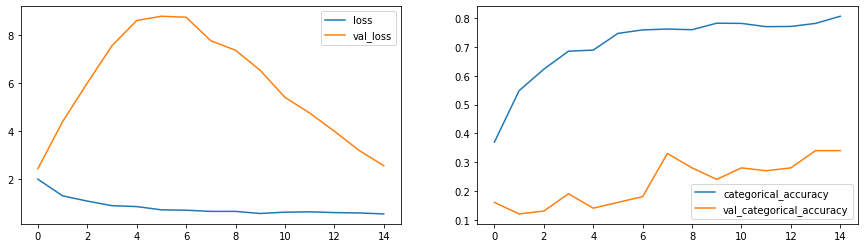

In [44]:
plot(history_model10)

## Model 8 with Augmentation
###  Reduce network parameters

In [45]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [46]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=130,image_width=130)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_44 (Conv3D)           (None, 16, 130, 130, 16)  1312      
_________________________________________________________________
activation_44 (Activation)   (None, 16, 130, 130, 16)  0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 16, 130, 130, 16)  64        
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 8, 65, 65, 16)     0         
_________________________________________________________________
conv3d_45 (Conv3D)           (None, 8, 65, 65, 32)     13856     
_________________________________________________________________
activation_45 (Activation)   (None, 8, 65, 65, 32)     0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 8, 65, 65, 32)   

In [47]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 627589
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7610 - categorical_accuracy: 0.3431
Epoch 00001: saving model to model_init_2021-07-2921_28_49.733064/model-00001-1.76100-0.34314-1.77622-0.21000.h5
34/34 [==============================] - 145s 4s/step - loss: 1.7610 - categorical_accuracy: 0.3431 - val_loss: 1.7762 - val_categorical_accuracy: 0.2100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1689 - categorical_accuracy: 0.5302
Epoch 00002: saving model to model_init_2021-07-2921_28_49.733064/model-00002-1.16889-0.53017-2.46757-0.22000.h5
34/34 [==============================] - 145s 4s/step - loss: 1.1689 - categorical_accuracy: 0.5302 - val_loss: 2.4676 - val_categorical_accuracy: 0.2200
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9911 - categorical_accuracy: 0.6078
Epoch 00003: saving model to model_init_2021-07-2921_28_49.733064/model-00003-0.99108-0.60784-2.83956-0.22000.h5
34/34 [=======

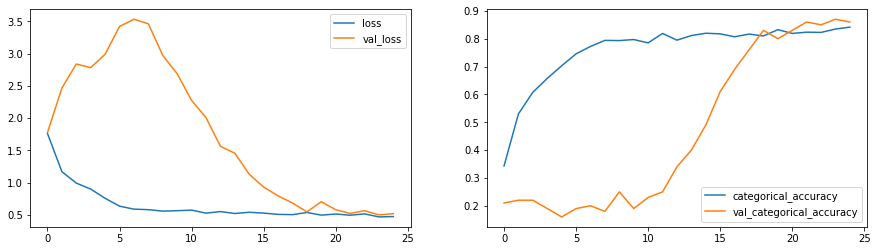

In [48]:
plot(history_model14)

## Model 9 - with Augmentation
### CNN LSTM with GRU 

In [49]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [50]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18, batch_size=20, num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 64)  

In [51]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4682 - categorical_accuracy: 0.3741
Epoch 00001: saving model to model_init_2021-07-2922_28_45.671273/model-00001-1.46820-0.37406-1.55446-0.33000.h5
34/34 [==============================] - 156s 5s/step - loss: 1.4682 - categorical_accuracy: 0.3741 - val_loss: 1.5545 - val_categorical_accuracy: 0.3300
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9324 - categorical_accuracy: 0.6523
Epoch 00002: saving model to model_init_2021-07-2922_28_45.671273/model-00002-0.93236-0.65234-1.83038-0.21000.h5
34/34 [==============================] - 155s 5s/step - loss: 0.9324 - categorical_accuracy: 0.6523 - val_loss: 1.8304 - val_categorical_accuracy: 0.2100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7331 - categorical_accuracy: 0.7172
Epoch 00003: saving model to model_init_2021-07-2922_28_45.671273/model-00003-0.73308-0.71719-2.15723-0.21000.h5
34/34 [======

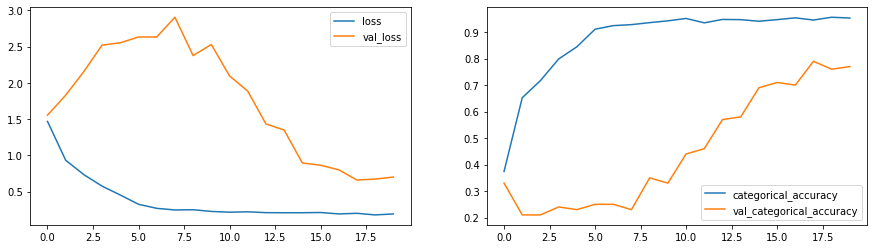

In [52]:
plot(history_model15)

### We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

# Consolidated Final Models


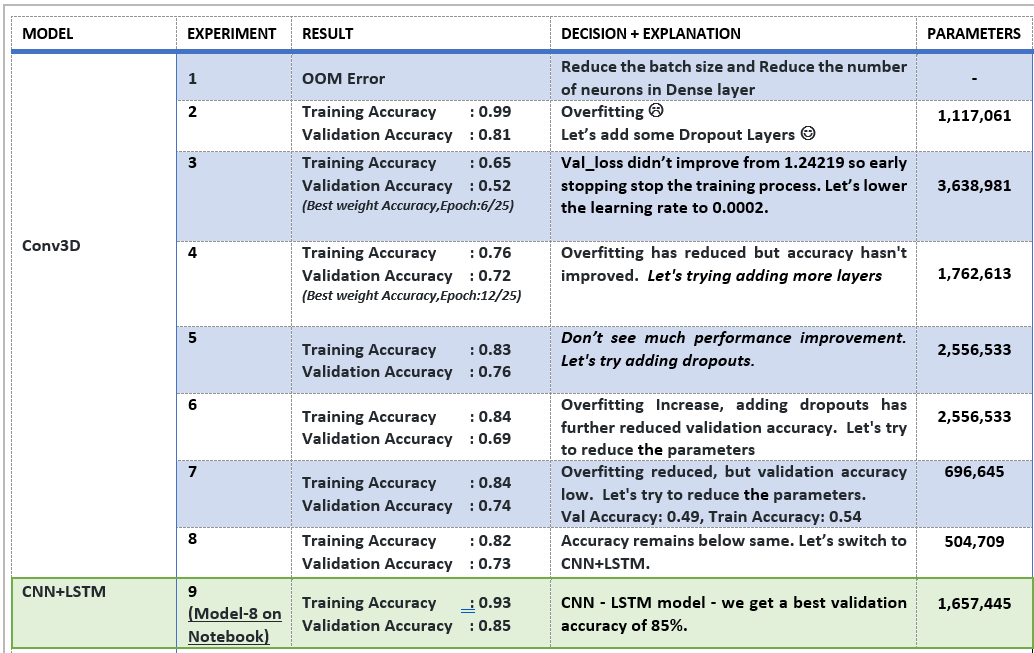
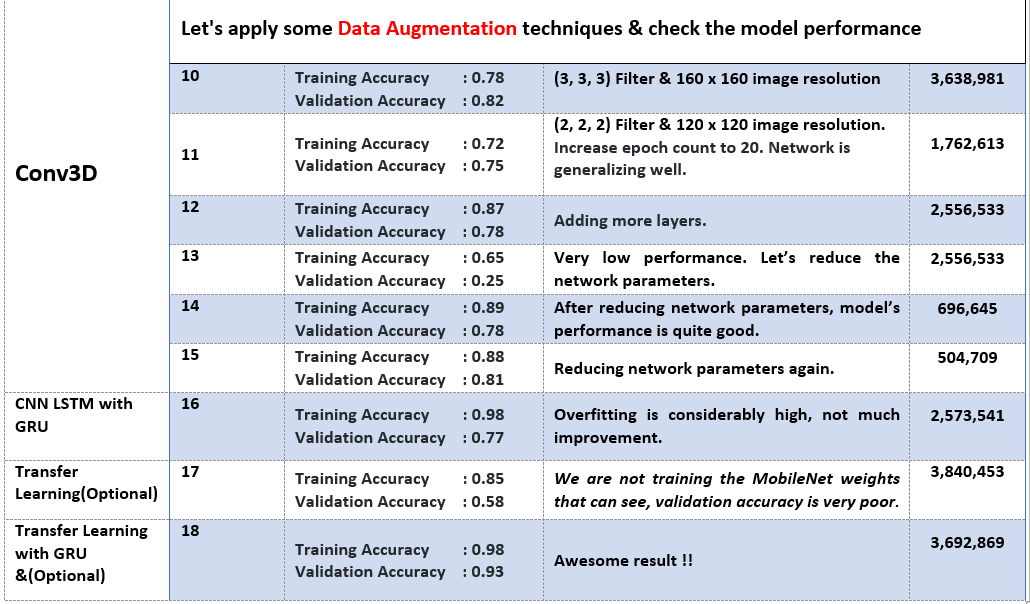

## After doing all the experiments, we finalized Model 6 - CNN+LSTM, which performed well.
__Reason:__

__- (Training Accuracy : 93%, Validation Accuracy : 85%)__

__- Number of Parameters(1,657,445)less according to other models performance__

__- Learning rate gradually decreacing after 16 Epoch__


__The best weights of CNN-LSTM: model-00020-0.19649-0.93514-0.45695-0.85000.h5 (19 MB). we considered this weight for model testing, Let's have look at the performance below__


# Loading model and Testing

In [17]:
import time
from keras.models import load_model
model = load_model('model_init_2021-07-2921_28_49.733064/model-00025-0.47257-0.84163-0.51755-0.86000.h5')

In [20]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=130,image_width=130)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [21]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [22]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[4 2 4 3 0 3 0 1 4 3 2 1 2 0 3 3 0 4 3 4]


### END OF ASSIGNMENT ###